In [1]:
!ls ../input/*

../input/competitive-data-science-predict-future-sales:
item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv

../input/pfs-dataprep:
__notebook__.ipynb  __results__.html   custom.css  mean_benchmark.csv
__output__.json     __results___files  data.h5	   prev_month_benchmark.csv


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import gc
from pathlib import Path
from math import sqrt
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, roc_auc_score

from fastai import tabular

In [3]:
SEED = 42
DATA_PATH = '../input/pfs-dataprep/data.h5'
TEMP_PATH = Path('temp')
# Number of rows for training
TRAIN_ROWS = 3000000 # (~10 months)
# Months to reserve for ensembling methods
META_MONTHS = 4
# Do not exclude target since fastai requires it in the dataframe
EXCL_COLS = []
CAT_COLS = ['month', 'shop_id', 'item_category_id', 'item_id', 'city_id', 'type_id', 'subtype_id']
FIXED_PARAMS = {
    'layers': [500, 200], 
    'ps': [0.3, 0.5], 
    'emb_drop': 0.2,
}
BATCH_SIZE = 512
PROCS = [tabular.FillMissing, tabular.Categorify, tabular.Normalize]

In [4]:
%%time
traintest = pd.read_hdf(DATA_PATH, key='traintest')

CPU times: user 11.1 s, sys: 3.94 s, total: 15.1 s
Wall time: 17.2 s


In [5]:
# Target column required for classification task
traintest['item_cnt_month_bin'] = (traintest['item_cnt_month'] > 0).astype('int32')

print(traintest.shape)

(7393103, 60)


In [6]:
train_idx = traintest[traintest.date_block_num<34-META_MONTHS].sample(n=TRAIN_ROWS, random_state=SEED).index
valid_idx = traintest[traintest.date_block_num==33].index
test_idx = traintest[traintest.date_block_num>=34-META_MONTHS].index

print(len(train_idx), len(valid_idx), len(test_idx))

3000000 238172 1114452


In [7]:
# fastai requires the validation set to be part of the training set
train_idx = train_idx.tolist() + valid_idx.tolist()
valid_range = range(len(train_idx)-len(valid_idx), len(train_idx))
X_train = traintest.loc[train_idx].drop(EXCL_COLS, axis=1)

print(len(X_train), len(valid_range))

3238172 238172


In [8]:
X_test = traintest.loc[test_idx].drop(EXCL_COLS, axis=1)

print(X_test.shape, sorted(X_test.date_block_num.unique()))

(1114452, 60) [30, 31, 32, 33, 34]


In [9]:
# Model parameters
CONT_NAMES = X_train.columns.difference(CAT_COLS + EXCL_COLS + ['item_cnt_month', 'item_cnt_month_bin'])
LIST_ARGS = {
    'path': TEMP_PATH,
    'cat_names': CAT_COLS,
    'cont_names': CONT_NAMES,
    'procs': PROCS
}

### Regression

In [10]:
def build_dataset(X_train, target, label_cls):
    # Construct fastai data blocks (extended torch data loaders) from dataframes
    test_data = tabular.TabularList.from_df(X_test, **LIST_ARGS)
    data = (tabular.TabularList.from_df(X_train, **LIST_ARGS)
            .split_by_idx(valid_range)
            .label_from_df(target, label_cls=label_cls)
            .add_test(test_data)
            .databunch(bs=BATCH_SIZE))
    return data

In [11]:
%%time
data = build_dataset(X_train, 'item_cnt_month', tabular.FloatList)

print(len(data.train_ds), len(data.valid_ds))

3000000 238172
CPU times: user 42.9 s, sys: 1min 14s, total: 1min 57s
Wall time: 1min 57s


In [12]:
(cat_x, cont_x), y = next(iter(data.train_dl))
for o in (cat_x, cont_x, y): print(o.shape)
print(tabular.to_np(y)[:5])

torch.Size([512, 7])
torch.Size([512, 51])
torch.Size([512])
[0. 0. 1. 0. 1.]


In [13]:
def set_random_seed():
    # This snippet gives repeatable results
    np.random.seed(SEED)
    tabular.torch.manual_seed(SEED)
    random.seed(SEED)
    if tabular.torch.cuda.is_available(): 
        tabular.torch.cuda.manual_seed(SEED)
        tabular.torch.cuda.manual_seed_all(SEED)
        tabular.torch.backends.cudnn.deterministic = True
        tabular.torch.backends.cudnn.benchmark = False
        
def rmse(y_true, y_pred):
    # Clipping required by the competition
    y_true = pd.Series(y_true).fillna(0).clip(0, 20).values
    y_pred = pd.Series(y_pred).fillna(0).clip(0, 20).values
    return sqrt(mean_squared_error(y_true, y_pred))

def setup_and_fit_model(data, use_sigmoid=False):
    # Set up the model
    set_random_seed()
    if use_sigmoid:
        set_random_seed()
        y_max = X_train['item_cnt_month'].max()
        y_range = tabular.torch.tensor([0, y_max], device=tabular.defaults.device)
        learn = tabular.tabular_learner(data, **FIXED_PARAMS, metrics=tabular.rmse, y_range=y_range)
    else:
        learn = tabular.tabular_learner(data, **FIXED_PARAMS, metrics=tabular.rmse)
    
    # Train and validate the model
    learn.fit_one_cycle(1, 1e-2, wd=0.2)
    valid_preds = learn.get_preds(tabular.DatasetType.Valid)
    
    # Generate predictions for the test set
    test_preds = learn.get_preds(tabular.DatasetType.Test)
    test_preds = test_preds[0].data.numpy().T[0]
    
    # fastai progress bar clears everything printed before, so print afterwards
    learn.recorder.plot_losses()
    print('RMSE:', rmse(valid_preds[1], valid_preds[0].squeeze()))
    
    # release unreferenced objects
    del learn
    gc.collect()
    return test_preds

RMSE: 1.0343356352631008
CPU times: user 1min 4s, sys: 10.6 s, total: 1min 14s
Wall time: 3min 34s


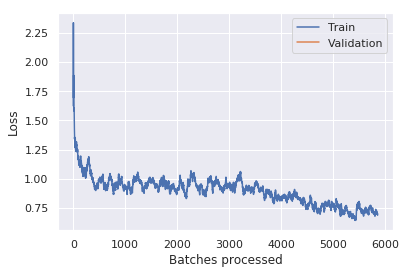

In [14]:
%%time
reg_preds = setup_and_fit_model(data)

RMSE: 0.9969908918980551
CPU times: user 1min 7s, sys: 10.5 s, total: 1min 17s
Wall time: 3min 36s


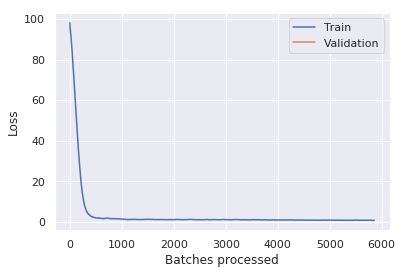

In [15]:
%%time
sigmoid_preds = setup_and_fit_model(data, use_sigmoid=True)

In [16]:
del data
gc.collect()

2644

### Binary classification

In [17]:
%%time
data = build_dataset(X_train, 'item_cnt_month_bin', tabular.CategoryList)

print(len(data.train_ds), len(data.valid_ds))

3000000 238172
CPU times: user 45.5 s, sys: 1min 20s, total: 2min 5s
Wall time: 2min 4s


In [18]:
(cat_x, cont_x), y = next(iter(data.train_dl))
for o in (cat_x, cont_x, y): print(o.shape)
print(tabular.to_np(y)[:5])

torch.Size([512, 7])
torch.Size([512, 51])
torch.Size([512])
[0 0 0 0 0]


In [19]:
def setup_and_fit_bin_model(data, use_class_weights=False):
    # Set up the model
    set_random_seed()
    if use_class_weights:
        # Use class weights in loss function for our imbalanced dataset
        value_counts = X_train['item_cnt_month'].value_counts()
        class_weights = tabular.FloatTensor([1/value_counts[0], 1/value_counts[1]]).cuda()
    else:
        class_weights = tabular.FloatTensor([1, 1]).cuda()
    loss_func = tabular.CrossEntropyFlat(weight=class_weights)
    learn = tabular.tabular_learner(data, **FIXED_PARAMS, metrics=tabular.accuracy, loss_func=loss_func)
    
    # Train and validate the model
    learn.fit_one_cycle(1, 1e-2, wd=0.2)
    valid_preds = learn.get_preds(tabular.DatasetType.Valid)
    
    # Generate predictions for the test set
    test_preds = learn.get_preds(tabular.DatasetType.Test)
    test_preds = test_preds[0].data.numpy()[:, 1]
    
    # fastai progress bar clears everything printed before, so print afterwards
    learn.recorder.plot_losses()
    print(confusion_matrix(valid_preds[1], valid_preds[0].argmax(dim=1)))
    print('ROCAUC:', roc_auc_score(valid_preds[1], valid_preds[0].argmax(dim=1)))
    
    return test_preds

[[200563   6138]
 [ 22026   9445]]
ROCAUC: 0.6352112508839429
CPU times: user 1min 5s, sys: 10.7 s, total: 1min 16s
Wall time: 3min 36s


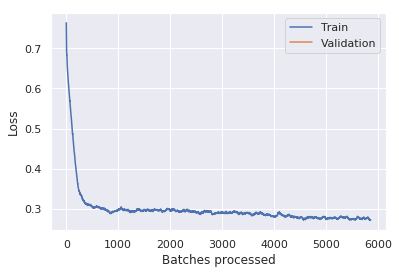

In [20]:
%%time
bin_preds = setup_and_fit_bin_model(data)

[[128148  78553]
 [  3884  27587]]
ROCAUC: 0.7482763827055254
CPU times: user 1min 7s, sys: 10.5 s, total: 1min 17s
Wall time: 3min 31s


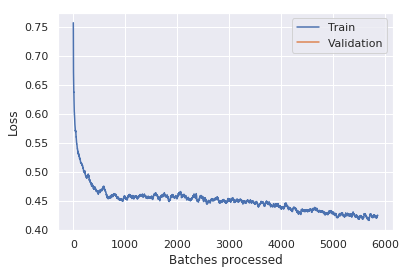

In [21]:
%%time
bin_weighted_preds = setup_and_fit_bin_model(data, use_class_weights=True)

### Save predictions

In [22]:
def save_preds(preds, fname):
    preds = pd.Series(preds, index=test_idx)
    preds.to_csv(fname)
    print(preds.head())
    print(preds.describe()[['mean', 'std', 'min', 'max']])

In [23]:
save_preds(reg_preds, 'reg_preds.csv')

6278651    0.203763
6278652    0.196599
6278653   -0.009731
6278654    0.074139
6278655    0.099263
dtype: float32
mean     0.318280
std      0.936165
min     -0.097603
max     41.664585
dtype: float64


In [24]:
save_preds(sigmoid_preds, 'sigmoid_preds.csv')

6278651    0.174408
6278652    0.158561
6278653    0.104735
6278654    0.107576
6278655    0.181897
dtype: float32
mean     0.357234
std      0.843014
min      0.004381
max     19.770159
dtype: float64


In [25]:
save_preds(bin_preds, 'bin_preds.csv')

6278651    0.182921
6278652    0.248968
6278653    0.015179
6278654    0.105771
6278655    0.147265
dtype: float32
mean    0.153830
std     0.188999
min     0.000018
max     1.000000
dtype: float64


In [26]:
save_preds(bin_weighted_preds, 'bin_weighted_preds.csv')

6278651    0.642152
6278652    0.762969
6278653    0.144590
6278654    0.535137
6278655    0.598447
dtype: float32
mean    0.447381
std     0.311033
min     0.000052
max     1.000000
dtype: float64
